# LAMPIRAN #02 - "ARTIFICIAL NEURAL NETWORK"

dataset - dapat diunduh di https://archive.ics.uci.edu/dataset/481/emg+data+for+gestures

Program ini akan berjalan seperti berikut:
* Import semua library python yang diperlukan
* Menghubungkan ke GDrive (semua data tersimpan di GDrive).
* Melakukan K-Fold Cross Valtidation (10 folds dengan 5 files tiap foldsnya).
* Membaca dan Proses semua file (50 file raw data) (load, clustering, separate class dan data, dan ekstraksi 8 fitur dengan metode statistik).
* Menyiapkan dataframe yang sudah diproses menjadi torch datasets.
* Mebuat dataloader (validasi dan training) dan padding datasetsnya agar memiliki panjang sequential yang sama.
* Melakukan proses training model dengan menggunakan CrossEntropyLoss sebagai Fungsi Loss dan menggunakan algoritma Adam untuk optimasi model dengan learning rate (lr) awal sebesar 0.3 dan dilakukan penyesuaian learning rate dengan menggunakan REDUCELRONPLATEAU, yaitu proses penyesuaian lr jika nilai loss evaluasi tidak berkurang lagi setelah 1 proses epoch dengan redaksi 0.5.
* Plot nilai Akurasi dan Loss dari hasil latih model tiap K-Folds nya.
* Menyimpan Akurasi dan Loss dari hasil evaluasi model akhir.
* Menampilkan Confusion matrik hasil dari evaluasi model untuk analisis lebih lanjut.
* Menghitung hasil akurasi keseluruhan model.

# Code berikut untuk menambah limit line dari Output Cell di G-Colab menjadi 50000 line.

In [ ]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# 1. IMPORT LIBRARIES
* Pandas -> pip install pandas || pip3 install pandas : https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html
* NumPy -> pip install numpy || pip3 install numpy : https://numpy.org/install/
* os - sudah terinstall secara otomatis.
* random - sudah terinstall secara otomatis.
* pickle - sudah terinstall secara otomatis.
* Matplotlib - pip install matplotlib || pip3 install matplotlib : https://matplotlib.org/stable/users/installing/index.html
* PyTorch - instal melalui Command dari: https://pytorch.org/get-started/locally/

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

# 2. Mendefinisikan Fungsi - Fungsi yang digunakan.

## DataProcessor - Mendefinisikan fungsi untuk memproses file
* fungsi read_files -> membaca dan menggabungkan semua file (.txt) dan merubahnya menjadi Pandas DataFrame.
* fungsi cluster_cluster_class_data -> untuk mengelompokkan kumpulan data dengan class atau labelnya.
* fungsi separate_class_data -> memisahkan dataframe menjadi data dan class.
* fungsi f_ekstrak -> membuat array 2d baru dengan ukuran 8 * 8 dengan tiap rownya merepresentasikan metode statistik yang digunakan dan kolom merepresentasikan channel dari sensornya.
** rerata -> menghitung nilai *mean* dari sequensial data per channelnya.
** standar_d -> menghitung nilai dari *standar deviasi* dari sequensial data per channelnya.
** RMS -> menghitung nilai dari *Root Mean Square* dari sequensial data per channelnya.
** MAbsolut -> menghitung nilai dari *Mean Absolut Value* dari sequensial data per channelnya.
** SimpleSI -> menghitung nilai dari *Simple Square Integral* dari sequensial data per channelnya.
** Variance -> menghitung nilai dari *Variance* dari sequensial data per channelnya.
** VarianceEMG -> menghitung nilai dari *Variance of EMG* dari sequensial data per channelnya.
** WaveformL -> menghitung nilai dari *Waveform Length* dari sequensial data per channelnya.

In [ ]:
class DataProcessor:
    def __init__(self, lokasi_data):
        self.lokasi_data = lokasi_data

    def read_files(self, data_list):
        combined_result = []

        for nama in data_list:
            data = pd.read_table(self.lokasi_data + nama)
            del data['time']
            data = data[data['class'] > 0]
            data['class'] = data['class'] - 1
            data.reset_index(drop=True, inplace=True)  # Use drop=True to avoid creating a new index
            dataframes = self.cluster_class_data(data)
            df_list = self.separate_class_data(dataframes)

            combined_result.extend(df_list)

        return combined_result

    def cluster_class_data(self, dataframe):
        dataframes = []
        current_class = None
        start_index = 0

        for index, row in dataframe.iterrows():
            if current_class is None or current_class != row['class']:
                if current_class is not None:
                    dataframes.append(dataframe.iloc[start_index:index])
                current_class = row['class']
                start_index = index

        dataframes.append(dataframe.iloc[start_index:])

        return dataframes

    def separate_class_data(self, dataframes):
        df_list = []

        for df in dataframes:
            class_value = int(df['class'].mode().iloc[0])
            data = df.iloc[:, 1:9].values
            fiture = self.f_ekstrak(data, 0)  # Use "self" to call instance methods
            df_list.append({"class": class_value, "data": fiture})

        return df_list

    def f_ekstrak(self, arr, i):  # Added "self" parameter
        H = np.zeros((8, 8))
        H[0, :] = self.rerata(arr, i)
        H[1, :] = self.standar_d(arr, i)
        H[2, :] = self.RMS(arr, i)
        H[3, :] = self.MAbsolut(arr, i)
        H[4, :] = self.SimpleSI(arr, i)
        H[5, :] = self.Variance(arr, i)  # Fixed method name
        H[6, :] = self.VarianceEMG(arr, i)  # Fixed method name
        H[7, :] = self.WaveformL(arr, i)

        return H  # Return the computed matrix H

    def rerata(self, arr, i):
        return np.mean(arr, axis=i)

    def standar_d(self, arr, i):
        return np.std(arr, axis=i, ddof=1)

    def RMS(self, arr, i):
        return np.sqrt(np.mean(np.square(arr), axis=i))

    def MAbsolut(self, arr, i):
        return np.mean(np.abs(arr), axis=i)

    def SimpleSI(self, arr, i):
        return np.sum(np.square(arr), axis=i)

    def Variance(self, arr, i):
        ws = arr.shape[0]  # Define ws based on the array shape
        return np.sum(np.square(arr - np.mean(arr)), axis=i) / (ws - 1)

    def VarianceEMG(self, arr, i):
        ws = arr.shape[0]  # Define ws based on the array shape
        return np.sum(np.square(arr), axis=i) / (ws - 1)

    def WaveformL(self, arr, i):
        j = i
        return np.sum(np.abs(np.diff(arr, n=1, axis=i)), axis=j)

<IPython.core.display.Javascript object>

## CustomDataset - Membuat Custom Torch dataset agar bisa menjadi masukan Model.
* Konversi tipe class menjadi tensor long.
* Konversi tipe data menjadi tensor float32.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample = self.data_list[idx]
        data = sample['data']
        return torch.tensor(data, dtype=torch.float32), torch.tensor(sample['class'], dtype=torch.long)

<IPython.core.display.Javascript object>

## Model ANN

Model ANN ini akan memiliki arsitektur sebagai berikut:
* flatten tensor menjadi 1d tensor dengan torch view.
* Layer fully connect atau layer clasifikasi
** fungsi Linear dari 8 * 8 (bentuk input dari hasil Pooling) menjadi 128.
** fungsi aktivasi ReLU.
** Dropout(0.5).
** fungsi Linear dari 128 menjadi 64.
** fungsi aktivasi ReLU.
** fungsi Linear dari 64 menjadi 32.
** fungsi aktivasi ReLU.
** fungsi Linear dari 32 menjadi 16.
** fungsi aktivasi ReLU.
** fungsi Linear dari 16 menjadi 6, karena data yang digunakan memiliki 6 class.

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.Classifikasi = nn.Sequential(
            nn.Linear(16, 6),
        ) # dengan output 6 class
        #self.LsoftMax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        x = self.Classifikasi(x)
        #x = self.LsoftMax(x)

        return x

<IPython.core.display.Javascript object>

## train_eval_model - untuk melakukan training dan evaluasi model.
* model akan dilatih dengan menggunakan algoritma sebagai berikut:
** load nilai data dan class model dalam dataloader.
** data akan dimasukkan kedalam model untuk dipelajari oleh model.
** hasil dari model yang dilatih kemudian dilakukan perhitungan torch.argmax untuk mencari index dari nilai terbesar (maksimal) dari suatu tensor.
** * Ex 1. bentuk dari *output* model ini adalah tensor dengan bentuk (Batch, 6). kemudan akan dilakukan perhitungan argmax pada dimensi 1 (tiap rows) sehingga hasil dari prediksi adalah sebuat tensor 1d atau tensor vektor berukuran batch.
** * Ex 2. jika hasil tensor *output* model adalah tensor([[3, 1, 4],[5, 2, 0]]). atau tensor 2*3 dengan 2 rows dan 3 colom, jika dilakukan perhitungan argmax untuk dimensi 1 atau tiap rows, maka untuk row pertama nilai maksimal adalah 4 dengan posisi index adalah 2, untuk row kedua nilai terbesar adalah 5 dengan posisi index adalah 0, sehingga *output* nya adalah [2, 0].
** kemudian dilakukan perhitungan Loss dari prediksi model, dengan cara membandingkan value dari hasil prediksi dan value dari nilai aktual.
** * untuk perhitungan nilai Loss ini menggunakan CrossEntropyLoss
** kemudian nilai gradient dari model akan kembali di-nol kan dengan optimasi zero_grad.
** akhirnya dilakukan proses back-propagation untuk optimasi nilai Loss agar nilai Loss mendekati 0.
** dilakukan pula hal yang sama untuk evaluasi model.
** setelah dilakukan evaluasi nilai loss dari hasil evaluasi model akan dijarikan pedoman untuk optimasi atau penyesuaian nilai learning rate dari model, jika nilai loss lebih besar dari nilai loss yang sebelumnya, maka nilai learning ratenya akan disesuaikan.
* Hasil dari fungsi ini adalah nilai akhir akurasi dan loss dari evaluasi model.

In [ ]:
def train_eval_model(model, criterion, optimizer, num_epochs, batch_size, device):
    min_train_loss = np.inf
    min_train_acc = 0.0
    tr_loss = np.zeros((num_epochs))
    acc_train = np.zeros((num_epochs))

    training_dataloader = DataLoader(CustomDataset_training, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()

        acc_all_train = []
        train_loss = []

        for x, y in training_dataloader:
            output = model(x.to(device))

            pred = torch.argmax(output, dim=1)
            acc_all_train.append(100 * (pred == y.to(device)).float().mean())

            loss = criterion(output, y.to(device))
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        acc_all_test = []
        test_loss = []

        with torch.no_grad():
            for x, yt in validasi_dataloader:
                output = model(x.to(device))

                preds = torch.argmax(output, dim=1)
                acc_all_test.append(100 * (preds == yt.to(device)).float().mean())

                loss = criterion(output, yt.to(device))
                test_loss.append(loss.item())

        test_loss = torch.tensor(test_loss)
        acc_all_test = torch.tensor(acc_all_test)

        avg_test_loss = test_loss.mean().item()
        avg_test_acc = acc_all_test.mean().item()

        pickle.dump(preds, open('acc_test.dump', 'wb'))
        pickle.dump(yt, open('test_target.dump', 'wb'))

        #scheduler.step()
        scheduler.step(test_loss)

        train_loss = torch.tensor(train_loss)
        tr_loss[epoch] = train_loss.mean()
        acc_all_train = torch.tensor(acc_all_train)
        acc_train[epoch] = acc_all_train.mean()

        pickle.dump(tr_loss, open('tr_loss.dump', 'wb'))
        pickle.dump(acc_train, open('acc_train.dump', 'wb'))

        print("Training model ... ({}/{}) \t Akurasi/Loss : {:.2f} % / {:.5f} || Evaluasi model Akurasi/Loss : {:.2f} % / {:.5f}".format(
            epoch+1, num_epochs,
            acc_train[epoch], tr_loss[epoch],
            avg_test_acc, avg_test_loss
        ))

    print(f'Trainig model Complated ... ({epoch+1}/{num_epochs}) \n')

    return avg_test_loss, avg_test_acc

<IPython.core.display.Javascript object>

## plot_loss_akurasi - Untuk ploting akurasi dan nilai loss model selama masa latih model.

In [ ]:
def plot_loss_akurasi(num_epochs):
  tr_loss = pickle.load(open('tr_loss.dump', 'rb'))
  acc_train = pickle.load(open('acc_train.dump', 'rb'))
  nama = list(labels)

  plt.close('all')
  fig = plt.figure(figsize=(8, 3))

  plt.subplot(121)
  x = np.array(range(1, num_epochs+1))
  plt.plot(x, acc_train, label = 'Train')
  plt.xlabel('Epochs')
  plt.ylabel('Akurasi (%)')
  plt.title(f'AKURASI TRAINING FOLD KE - {fold+1}')
  plt.grid()
  plt.legend()

  plt.subplot(122)
  plt.plot(x, tr_loss, label = 'Train')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'LOSS TRAINING FOLD KE - {fold+1}')
  plt.grid()
  plt.legend()

  plt.tight_layout()

  return plt.show()

<IPython.core.display.Javascript object>

## matrix - fungsi untuk menampilkan confusion matrix dari hasil evaluasi model.

In [ ]:
def matrix():
  acc_test = pickle.load(open('acc_test.dump', 'rb')).to(device)
  test_target = pickle.load(open('test_target.dump', 'rb')).to(device)

  y_real = pd.Series(test_target.cpu().numpy(), name = "Actual")
  y_pred = pd.Series(acc_test.cpu().numpy(), name = "Predicted")

  confusion_matrix = pd.crosstab(y_real, y_pred)
  return print(confusion_matrix)

<IPython.core.display.Javascript object>

# 3. MENGHUBUNGKAN KE GDRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

<IPython.core.display.Javascript object>

Mounted at /content/drive/


## Mendefinisikan lokasi file

In [ ]:
lokasi_data = r"/content/drive/MyDrive/Data/data_emg/datasets/"
files = os.listdir(lokasi_data)
datasets = [f for f in files if os.path.isfile(lokasi_data+'/'+f)]
#random.shuffle(datasets)

<IPython.core.display.Javascript object>

## Monitoring file - file yang digunakan.

In [ ]:
print(f'jumlah file yang digunakan : {len(datasets)}')
for i in datasets:
  print(i)

<IPython.core.display.Javascript object>

jumlah file yang digunakan : 50
2_raw_data_10-29_30.03.16.txt
2_raw_data_12-39_28.03.16.txt
1_raw_data_11-15_11.04.16.txt
1_raw_data_13-12_22.03.16.txt
1_raw_data_13-26_21.03.16.txt
2_raw_data_09-51_15.04.16.txt
1_raw_data_12-12_25.04.16.txt
1_raw_data_10-38_11.04.16.txt
1_raw_data_12-10_15.04.16.txt
2_raw_data_14-21_22.03.16.txt
2_raw_data_12-37_21.03.16.txt
2_raw_data_14-53_24.04.16.txt
1_raw_data_10-03_13.04.16.txt
2_raw_data_13-19_05.04.16.txt
1_raw_data_11-19_23.03.16.txt
2_raw_data_13-29_21.03.16.txt
1_raw_data_09-49_12.04.16.txt
2_raw_data_11-20_23.03.16.txt
2_raw_data_11-16_11.04.16.txt
2_raw_data_12-43_23.03.16.txt
2_raw_data_11-10_21.03.16.txt
2_raw_data_13-04_15.04.16.txt
2_raw_data_09-34_11.04.16.txt
1_raw_data_11-35_28.03.16.txt
1_raw_data_10-17_15.04.16.txt
1_raw_data_12-14_23.03.16.txt
2_raw_data_12-16_23.03.16.txt
1_raw_data_11-08_21.03.16.txt
1_raw_data_18-48_22.03.16.txt
1_raw_data_13-18_05.04.16.txt
2_raw_data_10-18_15.04.16.txt
2_raw_data_12-20_06.04.16.txt
2_raw_da

# 4. Proses pembuatan K-Fold, Proses data, Membuat Custom dataset, Membuat dataloader, Training dan Evaliuasi model, plot progres training model (akurasi dan loss), confusion matrix hasil evaluasi dan nilai akurasi dan loss evaluasi model, performa rata - rata model.
* Pembuatan K-Folds.
** Terdapat 10 folds dengan 5 files tiap foldsnya.
** Evaluasi 10% dari total files dan Training 90% dari total files.
* Membuat Custom dataset.
** Memproses Evaluasi dan Training hingga menjadi Custom tensor Datasets.
* Membuat dataloader.
** Memproses datasets evaluasi dan training menjadi evaluasi_dataloader dan training_dataloader.
* Melakukan proses Training dan Evaluasi model.
* Ploting progres training model (akurasi dan loss tiap epochs).
* Confusion Matrix
** Membuat confusion matrix hasil dari evaluasi model.
** Menampilkan performa evaluasi model (akurasi dan loss)
* Performa rata - rata model.
** Menghitung nilai rereta hasil evaluasi model tiap fold nya (akurasi dan loss).

<IPython.core.display.Javascript object>

Total Validasi Class (5 files per K-Fold):
0    10
1    10
2    10
3    10
4    10
5    10
dtype: int64

 ANN(
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=16, bias=True)
    (8): ReLU()
  )
  (Classifikasi): Sequential(
    (0): Linear(in_features=16, out_features=6, bias=True)
  )
)

K-Fold ... (1/10)
Training model ... (1/50) 	 Akurasi/Loss : 17.41 % / 7.44748 || Evaluasi model Akurasi/Loss : 16.67 % / 1.79715
Training model ... (2/50) 	 Akurasi/Loss : 20.00 % / 1.84082 || Evaluasi model Akurasi/Loss : 16.67 % / 1.79264
Training model ... (3/50) 	 Akurasi/Loss : 24.26 % / 1.80955 || Evaluasi model Akurasi/Loss : 33.33 % / 1.62747
Training model ... (4/50) 	 Akurasi/Loss : 34.07 % / 1.74642 || Evalu

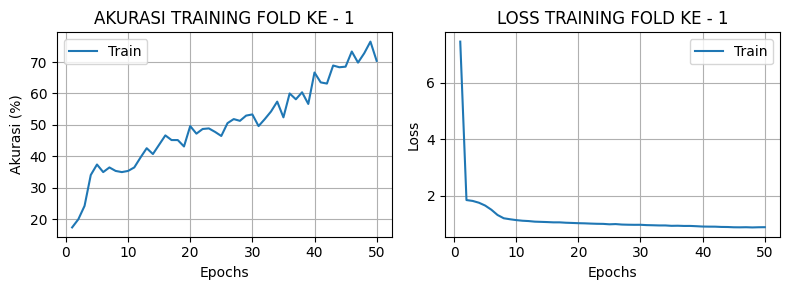



Predicted   0  1  2  3  4   5
Actual                       
0          10  0  0  0  0   0
1           0  9  1  0  0   0
2           0  0  8  2  0   0
3           0  0  0  6  1   3
4           0  0  0  0  0  10
5           0  0  0  0  0  10

Akurasi||Loss model : 71.67% || 0.86916 


K-Fold ... (2/10)
Training model ... (1/50) 	 Akurasi/Loss : 76.67 % / 0.86261 || Evaluasi model Akurasi/Loss : 83.33 % / 0.83492
Training model ... (2/50) 	 Akurasi/Loss : 76.11 % / 0.85555 || Evaluasi model Akurasi/Loss : 85.00 % / 0.83283
Training model ... (3/50) 	 Akurasi/Loss : 73.70 % / 0.85021 || Evaluasi model Akurasi/Loss : 81.67 % / 0.82497
Training model ... (4/50) 	 Akurasi/Loss : 77.22 % / 0.84672 || Evaluasi model Akurasi/Loss : 83.33 % / 0.83676
Training model ... (5/50) 	 Akurasi/Loss : 74.26 % / 0.84128 || Evaluasi model Akurasi/Loss : 86.67 % / 0.82650
Training model ... (6/50) 	 Akurasi/Loss : 78.33 % / 0.83266 || Evaluasi model Akurasi/Loss : 78.33 % / 0.81202
Training model ... (7/50

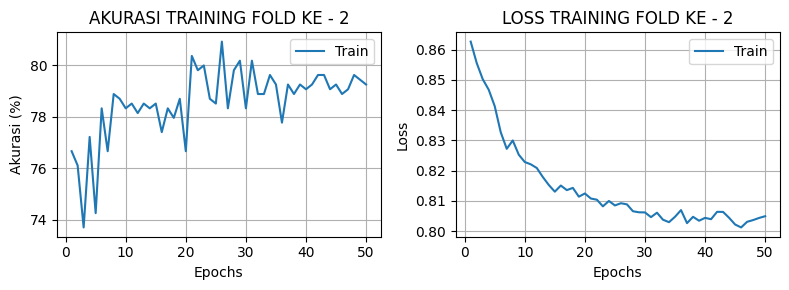



Predicted   0   1   2   3  4   5
Actual                          
0          10   0   0   0  0   0
1           0  10   0   0  0   0
2           0   0  10   0  0   0
3           0   0   0  10  0   0
4           0   0   0   0  2   8
5           0   0   0   0  0  10

Akurasi||Loss model : 86.67% || 0.79341 


K-Fold ... (3/10)
Training model ... (1/50) 	 Akurasi/Loss : 78.33 % / 0.81278 || Evaluasi model Akurasi/Loss : 81.67 % / 0.80874
Training model ... (2/50) 	 Akurasi/Loss : 78.52 % / 0.80374 || Evaluasi model Akurasi/Loss : 83.33 % / 0.78868
Training model ... (3/50) 	 Akurasi/Loss : 81.30 % / 0.79989 || Evaluasi model Akurasi/Loss : 75.00 % / 0.78224
Training model ... (4/50) 	 Akurasi/Loss : 78.33 % / 0.79328 || Evaluasi model Akurasi/Loss : 83.33 % / 0.77744
Training model ... (5/50) 	 Akurasi/Loss : 80.00 % / 0.79061 || Evaluasi model Akurasi/Loss : 83.33 % / 0.77343
Training model ... (6/50) 	 Akurasi/Loss : 80.74 % / 0.79373 || Evaluasi model Akurasi/Loss : 88.33 % / 0.78622


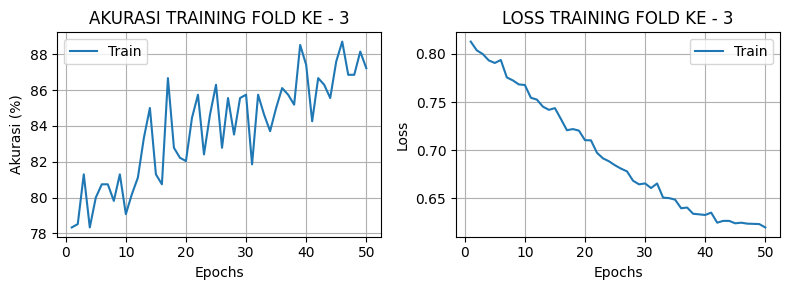



Predicted   0   1   2   3  4   5
Actual                          
0          10   0   0   0  0   0
1           0  10   0   0  0   0
2           0   0  10   0  0   0
3           0   0   0  10  0   0
4           0   0   0   0  6   4
5           0   0   0   0  0  10

Akurasi||Loss model : 93.33% || 0.61364 


K-Fold ... (4/10)
Training model ... (1/50) 	 Akurasi/Loss : 87.59 % / 0.62417 || Evaluasi model Akurasi/Loss : 80.00 % / 0.63806
Training model ... (2/50) 	 Akurasi/Loss : 85.00 % / 0.61891 || Evaluasi model Akurasi/Loss : 90.00 % / 0.62732
Training model ... (3/50) 	 Akurasi/Loss : 87.22 % / 0.61334 || Evaluasi model Akurasi/Loss : 85.00 % / 0.62702
Training model ... (4/50) 	 Akurasi/Loss : 84.07 % / 0.60800 || Evaluasi model Akurasi/Loss : 83.33 % / 0.62142
Training model ... (5/50) 	 Akurasi/Loss : 84.81 % / 0.61110 || Evaluasi model Akurasi/Loss : 91.67 % / 0.62142
Training model ... (6/50) 	 Akurasi/Loss : 85.56 % / 0.62888 || Evaluasi model Akurasi/Loss : 88.33 % / 0.61561


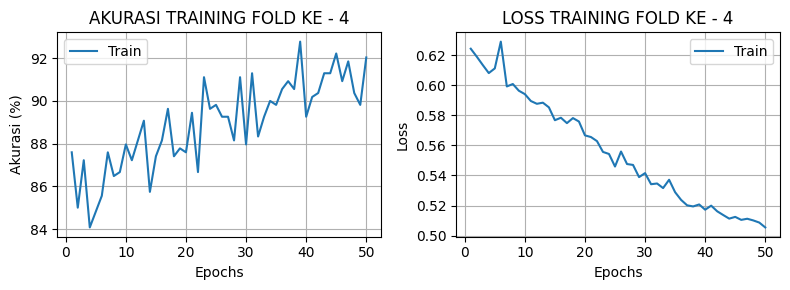



Predicted   0   1  2  3  4   5
Actual                        
0          10   0  0  0  0   0
1           0  10  0  0  0   0
2           0   0  8  2  0   0
3           0   0  0  8  2   0
4           0   0  0  0  8   2
5           0   0  0  0  0  10

Akurasi||Loss model : 90.00% || 0.52358 


K-Fold ... (5/10)
Training model ... (1/50) 	 Akurasi/Loss : 90.19 % / 0.52052 || Evaluasi model Akurasi/Loss : 96.67 % / 0.48712
Training model ... (2/50) 	 Akurasi/Loss : 92.04 % / 0.50806 || Evaluasi model Akurasi/Loss : 91.67 % / 0.51675
Training model ... (3/50) 	 Akurasi/Loss : 89.26 % / 0.50904 || Evaluasi model Akurasi/Loss : 95.00 % / 0.50134
Training model ... (4/50) 	 Akurasi/Loss : 91.85 % / 0.50102 || Evaluasi model Akurasi/Loss : 98.33 % / 0.48464
Training model ... (5/50) 	 Akurasi/Loss : 91.67 % / 0.50191 || Evaluasi model Akurasi/Loss : 95.00 % / 0.47894
Training model ... (6/50) 	 Akurasi/Loss : 89.81 % / 0.50147 || Evaluasi model Akurasi/Loss : 95.00 % / 0.49548
Training model .

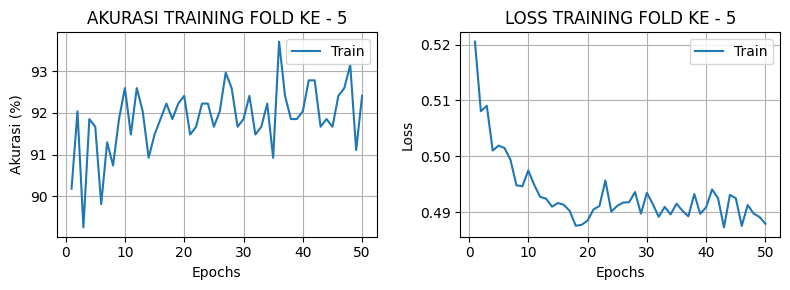



Predicted   0   1   2   3  4   5
Actual                          
0          10   0   0   0  0   0
1           0  10   0   0  0   0
2           0   0  10   0  0   0
3           0   0   0  10  0   0
4           0   0   0   0  9   1
5           0   0   0   0  0  10

Akurasi||Loss model : 98.33% || 0.48114 


K-Fold ... (6/10)
Training model ... (1/50) 	 Akurasi/Loss : 90.56 % / 0.50005 || Evaluasi model Akurasi/Loss : 86.67 % / 0.48761
Training model ... (2/50) 	 Akurasi/Loss : 91.67 % / 0.49446 || Evaluasi model Akurasi/Loss : 95.00 % / 0.49298
Training model ... (3/50) 	 Akurasi/Loss : 91.11 % / 0.49605 || Evaluasi model Akurasi/Loss : 90.00 % / 0.48070
Training model ... (4/50) 	 Akurasi/Loss : 91.30 % / 0.49750 || Evaluasi model Akurasi/Loss : 78.33 % / 0.49897
Training model ... (5/50) 	 Akurasi/Loss : 90.19 % / 0.49904 || Evaluasi model Akurasi/Loss : 96.67 % / 0.48168
Training model ... (6/50) 	 Akurasi/Loss : 92.59 % / 0.49002 || Evaluasi model Akurasi/Loss : 93.33 % / 0.47531


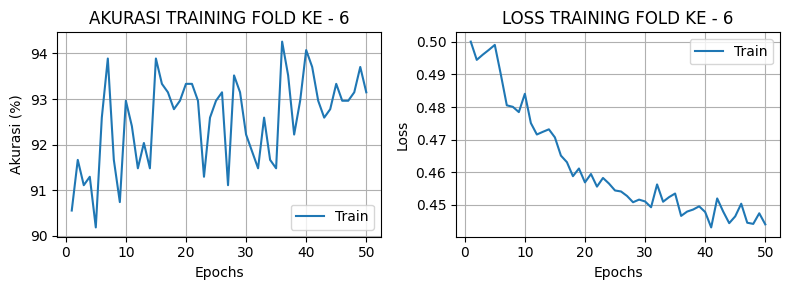



Predicted   0   1   2   3  4   5
Actual                          
0          10   0   0   0  0   0
1           0  10   0   0  0   0
2           0   0  10   0  0   0
3           0   0   0  10  0   0
4           0   0   0   0  6   4
5           0   0   0   0  0  10

Akurasi||Loss model : 93.33% || 0.44215 


K-Fold ... (7/10)
Training model ... (1/50) 	 Akurasi/Loss : 85.19 % / 0.47655 || Evaluasi model Akurasi/Loss : 98.33 % / 0.44158
Training model ... (2/50) 	 Akurasi/Loss : 88.89 % / 0.46061 || Evaluasi model Akurasi/Loss : 95.00 % / 0.43843
Training model ... (3/50) 	 Akurasi/Loss : 90.00 % / 0.46016 || Evaluasi model Akurasi/Loss : 91.67 % / 0.43043
Training model ... (4/50) 	 Akurasi/Loss : 92.78 % / 0.45360 || Evaluasi model Akurasi/Loss : 91.67 % / 0.43642
Training model ... (5/50) 	 Akurasi/Loss : 90.56 % / 0.44457 || Evaluasi model Akurasi/Loss : 91.67 % / 0.43377
Training model ... (6/50) 	 Akurasi/Loss : 91.30 % / 0.44583 || Evaluasi model Akurasi/Loss : 90.00 % / 0.42849


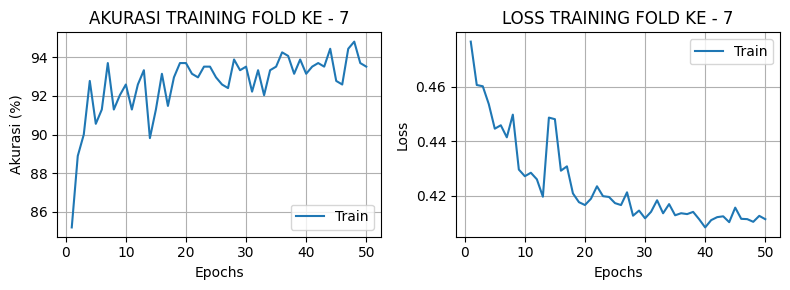



Predicted   0   1   2   3  4   5
Actual                          
0          10   0   0   0  0   0
1           0  10   0   0  0   0
2           0   0  10   0  0   0
3           0   0   0  10  0   0
4           0   0   0   1  5   4
5           0   0   0   0  0  10

Akurasi||Loss model : 91.67% || 0.39903 



<ipython-input-3-b97f439e22e5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'] - 1



K-Fold ... (8/10)
Training model ... (1/50) 	 Akurasi/Loss : 89.44 % / 0.47236 || Evaluasi model Akurasi/Loss : 96.67 % / 0.41932
Training model ... (2/50) 	 Akurasi/Loss : 86.85 % / 0.45956 || Evaluasi model Akurasi/Loss : 96.67 % / 0.42761
Training model ... (3/50) 	 Akurasi/Loss : 91.67 % / 0.44234 || Evaluasi model Akurasi/Loss : 100.00 % / 0.41426
Training model ... (4/50) 	 Akurasi/Loss : 91.30 % / 0.43276 || Evaluasi model Akurasi/Loss : 100.00 % / 0.40189
Training model ... (5/50) 	 Akurasi/Loss : 91.11 % / 0.44453 || Evaluasi model Akurasi/Loss : 100.00 % / 0.41076
Training model ... (6/50) 	 Akurasi/Loss : 90.56 % / 0.44094 || Evaluasi model Akurasi/Loss : 100.00 % / 0.41051
Training model ... (7/50) 	 Akurasi/Loss : 92.41 % / 0.43301 || Evaluasi model Akurasi/Loss : 100.00 % / 0.40884
Training model ... (8/50) 	 Akurasi/Loss : 91.67 % / 0.42020 || Evaluasi model Akurasi/Loss : 96.67 % / 0.40753
Training model ... (9/50) 	 Akurasi/Loss : 92.04 % / 0.42295 || Evaluasi model A

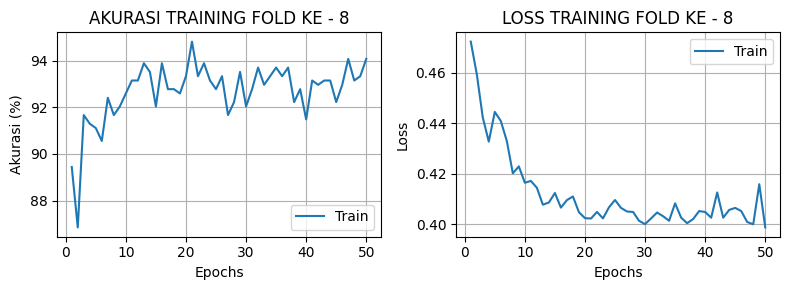



Predicted   0   1   2   3   4   5
Actual                           
0          10   0   0   0   0   0
1           0  10   0   0   0   0
2           0   0  10   0   0   0
3           0   0   0  10   0   0
4           0   0   0   0  10   0
5           0   0   0   0   0  10

Akurasi||Loss model : 100.00% || 0.39848 


K-Fold ... (9/10)
Training model ... (1/50) 	 Akurasi/Loss : 91.11 % / 0.42481 || Evaluasi model Akurasi/Loss : 98.33 % / 0.40390
Training model ... (2/50) 	 Akurasi/Loss : 92.22 % / 0.40565 || Evaluasi model Akurasi/Loss : 98.33 % / 0.38579
Training model ... (3/50) 	 Akurasi/Loss : 91.85 % / 0.41574 || Evaluasi model Akurasi/Loss : 96.67 % / 0.38621
Training model ... (4/50) 	 Akurasi/Loss : 91.85 % / 0.43581 || Evaluasi model Akurasi/Loss : 100.00 % / 0.39055
Training model ... (5/50) 	 Akurasi/Loss : 92.22 % / 0.44031 || Evaluasi model Akurasi/Loss : 96.67 % / 0.40023
Training model ... (6/50) 	 Akurasi/Loss : 90.19 % / 0.41575 || Evaluasi model Akurasi/Loss : 96.67 % 

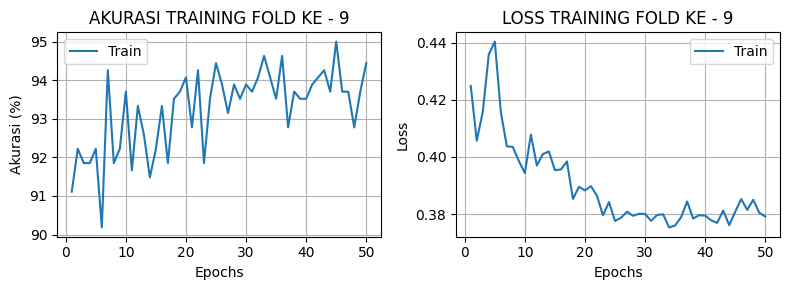



Predicted   0   1   2   3   4   5
Actual                           
0          10   0   0   0   0   0
1           0  10   0   0   0   0
2           0   0  10   0   0   0
3           0   0   0  10   0   0
4           0   0   0   0  10   0
5           0   0   0   0   0  10

Akurasi||Loss model : 100.00% || 0.37413 


K-Fold ... (10/10)
Training model ... (1/50) 	 Akurasi/Loss : 89.07 % / 0.44801 || Evaluasi model Akurasi/Loss : 98.33 % / 0.39000
Training model ... (2/50) 	 Akurasi/Loss : 91.48 % / 0.41068 || Evaluasi model Akurasi/Loss : 98.33 % / 0.36878
Training model ... (3/50) 	 Akurasi/Loss : 90.19 % / 0.40260 || Evaluasi model Akurasi/Loss : 98.33 % / 0.35974
Training model ... (4/50) 	 Akurasi/Loss : 93.70 % / 0.38146 || Evaluasi model Akurasi/Loss : 98.33 % / 0.35851
Training model ... (5/50) 	 Akurasi/Loss : 90.19 % / 0.38977 || Evaluasi model Akurasi/Loss : 98.33 % / 0.35862
Training model ... (6/50) 	 Akurasi/Loss : 90.19 % / 0.39359 || Evaluasi model Akurasi/Loss : 98.33 % 

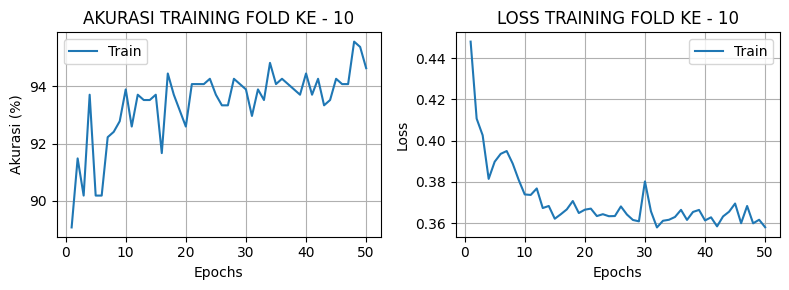



Predicted   0   1  2   3   4   5
Actual                          
0          10   0  0   0   0   0
1           0  10  0   0   0   0
2           0   0  9   1   0   0
3           0   0  0  10   0   0
4           0   0  0   0  10   0
5           0   0  0   0   0  10

Akurasi||Loss model : 98.33% || 0.35082 



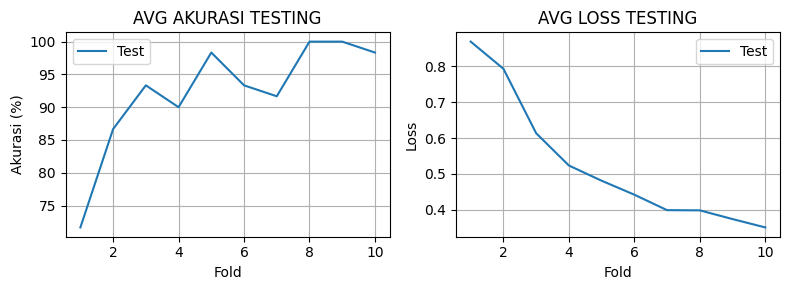



Performa rata - rata model Akurasi||Loss : 92.33% +- 8.54%||0.52456 +- 0.18016


In [ ]:
# Pseudocode
num_folds = 10
files_per_fold = len(datasets)/num_folds
#files_per_fold = 5

data_processor = DataProcessor(lokasi_data)
processed_datasets = data_processor.read_files(datasets[:int(files_per_fold)])

class_count = []
for i in range(len(processed_datasets)):
  class_count.append(processed_datasets[i]['class'])
labels = np.unique(class_count)
class_count = pd.DataFrame(class_count)
print(f"Total Validasi Class ({int(files_per_fold)} files per K-Fold):")
print(class_count.value_counts())


model = ANN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("\n",model)

batch_size = 18
num_epochs = 50

avg_acc = []
avg_loss = []
for fold in range(num_folds):

    learning_rate = 0.001
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Calculate start and end indices for the validation files
    start_idx = int(fold * files_per_fold)
    end_idx = int((fold + 1) * files_per_fold)

    validasi = datasets[start_idx:end_idx]
    training = datasets[:start_idx] + datasets[end_idx:]

    #data_processor = DataProcessor(lokasi_data)
    processed_validasi = data_processor.read_files(validasi)
    processed_training = data_processor.read_files(training)

    CustomDataset_validasi = CustomDataset(processed_validasi)
    CustomDataset_training = CustomDataset(processed_training)

    validasi_dataloader = DataLoader(CustomDataset_validasi, batch_size=int(len(processed_validasi)))
    #training_dataloader = DataLoader(CustomDataset_training, batch_size=batch_size, shuffle=True)

    print(f"\nK-Fold ... ({fold+1}/{num_folds})")

    #train_model(model, criterion, optimizer, num_epochs, batch_size, device)

    #model.load_state_dict(torch.load("/content/drive/MyDrive/data/data_emg/models/bestmodel_var_cnn.mdl"))
    #test_loss, test_accuracy = evaluate_model(model, criterion, validasi_dataloader, device)
    test_loss, test_accuracy = train_eval_model(model, criterion, optimizer, num_epochs, batch_size, device)
    plot_loss_akurasi(num_epochs)
    print("\n")
    matrix()
    avg_acc.append(test_accuracy)
    avg_loss.append(test_loss)
    print(f"\nAkurasi||Loss model : {test_accuracy:.2f}% || {test_loss:.5f} \n")


plt.close('all')
fig = plt.figure(figsize=(8, 3))

plt.subplot(122)
x = np.array(range(1, num_folds+1))
plt.plot(x, avg_loss, label = 'Test')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('AVG LOSS TESTING')
plt.grid()
plt.legend()

plt.subplot(121)
plt.plot(x, avg_acc, label = 'Test')
plt.xlabel('Fold')
plt.ylabel('Akurasi (%)')
plt.title('AVG AKURASI TESTING')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

acc = torch.tensor(avg_acc).mean()
loss = torch.tensor(avg_loss).mean()
d_acc = torch.tensor(avg_acc).std()
d_loss = torch.tensor(avg_loss).std()

print(f"\n\nPerforma rata - rata model Akurasi||Loss : {acc:.2f}% +- {d_acc:.2f}%||{loss:.5f} +- {d_loss:.5f}")

In [ ]:
avg_acc

<IPython.core.display.Javascript object>

[71.66667175292969,
 86.66667175292969,
 93.33334350585938,
 90.0,
 98.33334350585938,
 93.33334350585938,
 91.66667175292969,
 100.0,
 100.0,
 98.33334350585938]

In [ ]:
avg_loss

<IPython.core.display.Javascript object>

[0.8691636919975281,
 0.7934108972549438,
 0.6136378049850464,
 0.5235820412635803,
 0.4811429977416992,
 0.4421537518501282,
 0.39903467893600464,
 0.3984772562980652,
 0.37412533164024353,
 0.3508235216140747]

# 5. REFERENSI CODING
`IMPORT LIB`
* https://docs.python.org/3/library/glob.html
* https://docs.python.org/3/library/os.html
* https://docs.python.org/3/library/pickle.html
***
`PANDAS`
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mode.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html
***
`NUMPY`
* https://numpy.org/doc/stable/reference/generated/numpy.mean.html
* https://numpy.org/doc/stable/reference/generated/numpy.std.html
* https://numpy.org/doc/stable/reference/generated/numpy.square.html
* https://numpy.org/doc/stable/reference/generated/numpy.absolute.html
* https://numpy.org/doc/stable/reference/generated/numpy.sum.html
* https://numpy.org/doc/stable/reference/generated/numpy.diff.html
* https://numpy.org/devdocs/reference/generated/numpy.shape.html
* https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
* https://numpy.org/doc/stable/reference/generated/numpy.array.html
* https://numpy.org/doc/stable/reference/generated/numpy.arange.html
* https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
* https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html
* https://numpy.org/doc/stable/reference/generated/numpy.unique.html
***
`PYTORCH`
* https://pytorch.org/docs/stable/tensors.html
* https://pytorch.org/docs/stable/generated/torch.mean.html
* https://pytorch.org/docs/stable/generated/torch.std.html
* https://pytorch.org/docs/stable/generated/torch.argmax.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.item.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
* https://pytorch.org/docs/stable/cuda.html
* https://pytorch.org/docs/stable/generated/torch.cuda.is_available.html
* https://pytorch.org/docs/stable/data.html
* https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
* https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
* https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
* https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters
* https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
* https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
* https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
* https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval
* https://pytorch.org/docs/stable/optim.html
* https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
* https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#reducelronplateau
* https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
* https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html
* https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
*
***
`MATPLOTLIB`
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.close.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylabel.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
***
`PICKLE`
* https://docs.python.org/3/library/pickle.html#pickle.dumps
* https://docs.python.org/3/library/pickle.html#pickle.load
***
`OS`
* https://docs.python.org/3/library/os.html#os.listdir
* https://docs.python.org/3/library/os.path.html#os.path.isfile